# Classifying text with Transformers!
In this tutorial, we'll explore the versatility of attention mechanisms in handling sequential data processing tasks. Traditionally, recurrent neural networks (RNNs) and LSTM networks were commonly used for such tasks. However, with the emergence of Transformer architectures, attention mechanisms have gained prominence. We'll investigate how attention mechanisms, when used independently, efficiently capture dependencies between tokens in a sequence, eliminating the need for recurrent layers.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import re
import io
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

# We'll be using Pytorch's text library called torchtext!
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T


In [3]:
# # Load the dataset using pandas
# import pandas as pd
# df = pd.read_csv('dataset_directory/your_dataset.csv') # Replace 'your_dataset.csv' with the actual file name

# print(df.head())

In [4]:
import os

# Tạo thư mục mới
folder_path = "/kaggle/working/ag-news-classification-dataset"
os.makedirs(folder_path, exist_ok=True)

print(f"Thư mục '{folder_path}' đã được tạo.")


Thư mục '/kaggle/working/ag-news-classification-dataset' đã được tạo.


In [5]:
# Define the hyperparameters
# Learning rate for the optimizer
learning_rate = 1e-4

# Number of epochs for training
nepochs = 20

# Batch size for data loaders
batch_size = 128

# Maximum sequence length for text inputs
max_len = 128

# Root directory of the dataset
data_set_root = "/kaggle/input/ag-news-classification-dataset"
output_root = "/kaggle/working/ag-news-classification-dataset"

## Data processing and Tokenization

In [6]:
# We'll be using the AG News Dataset
# Which contains a short news article and a single label to classify the "type" of article
# Note that for torchtext these datasets are NOT Pytorch dataset classes "AG_NEWS" is a function that
# returns a Pytorch DataPipe!

# Pytorch DataPipes vvv
# https://pytorch.org/data/main/torchdata.datapipes.iter.html

# vvv Good Blog on the difference between DataSet and DataPipe
# https://medium.com/deelvin-machine-learning/comparison-of-pytorch-dataset-and-torchdata-datapipes-486e03068c58
# Depending on the dataset sometimes the dataset doesn't download and gives an error
# and you'll have to download and extract manually
# "The datasets supported by torchtext are datapipes from the torchdata project, which is still in Beta status"

# Un-comment to triger the DataPipe to download the data vvv
# dataset_train = AG_NEWS(root=data_set_root, split="train")
# data = next(iter(dataset_train))

# Side-Note I've noticed that the WikiText dataset is no longer able to be downloaded :(

In [7]:
# Un-Comment to train sentence-piece model for tokenizer and vocab!

from torchtext.data.functional import generate_sp_model

with open(os.path.join(data_set_root, "train.csv")) as f:
    with open(os.path.join(output_root, "data.txt"), "w") as f2:
        for i, line in enumerate(f):
            text_only = "".join(line.split(",")[1:])
            filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' ')) # remove newline characters
            filtered = filtered.replace(' #39;', "'")
            filtered = filtered.replace(' #38;', "&")
            filtered = filtered.replace(' #36;', "$")
            filtered = filtered.replace(' #151;', "-")

            f2.write(filtered.lower() + "\n")

generate_sp_model(os.path.join(output_root, "data.txt"),
                  vocab_size=20000, model_prefix='/kaggle/working/ag-news-classification-dataset/spm_ag_news')

# 1. data.txt: Chứa văn bản thô dùng để huấn luyện SentencePiece.
# Ví dụ: Mỗi dòng chứa một bài báo trong tập dữ liệu AG News, đã được làm sạch.

# 2. spm_ag_news.model: Mô hình SentencePiece đã huấn luyện, dùng để tách từ thành các phần nhỏ hơn.
# Ví dụ: Mô hình này sẽ tách từ "unbreakable" thành "un", "break", "able".

# 3. spm_ag_news.vocab: Danh sách các phần từ đã học, mỗi phần có một ID riêng.
# Ví dụ: Tập tin này sẽ chứa "un", "break", "able" cùng với các từ và phần từ khác được học từ data.txt.

# Tóm lại: data.txt là dữ liệu đầu vào, spm_ag_news.model là bộ não phân tách từ,
# và spm_ag_news.vocab là từ điển chứa các phần từ.

# Giả sử file train.csv có nội dung như sau:


# Class,Title,Description
# 1,Wall St. Bears Claw Back Into the Black,NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
# 2,Reuters Sports News,SYDNEY (Reuters) - The Wallabies will play their third Bledisloe\Cup test against the All Blacks this season.
# Use code with caution
# Bước 1: Tạo data.txt

# Đoạn mã sẽ đọc từng dòng trong train.csv, làm sạch dữ liệu (ví dụ: thay thế \n bằng khoảng trắng,...) và kết hợp cột Title và Description thành một cột duy nhất là Article.
# Sau đó, nội dung của cột Article được chuyển thành chữ thường và ghi vào data.txt.
# Kết quả file data.txt sẽ như sau:


# wall st. bears claw back into the black : new york (reuters) - short-sellers, wall street's dwindling band of ultra-cynics, are seeing green again.
# reuters sports news : sydney (reuters) - the wallabies will play their third bledisloe cup test against the all blacks this season.
# Use code with caution
# Bước 2: Huấn luyện SentencePiece và tạo spm_ag_news.model & spm_ag_news.vocab

# Hàm generate_sp_model sẽ sử dụng nội dung trong data.txt để huấn luyện mô hình SentencePiece.
# Quá trình huấn luyện này sẽ phân tích tần suất xuất hiện của các từ và cụm từ trong data.txt để tạo ra một tập hợp các phần tử (token) tối ưu.
# Mô hình SentencePiece đã được huấn luyện sẽ được lưu vào file spm_ag_news.model (chỉ là model pretrain).
# Danh sách các token và ID tương ứng sẽ được lưu vào file spm_ag_news.vocab.
# Ví dụ nội dung của spm_ag_news.vocab:


# <pad>    0
# <sos>    1
# <eos>    2
# <unk>    3
#  the     4
# .       5
# ,       6
#  of      7
#  to      8
#  and     9
# ...
# Use code with caution
# Bước 3: Sử dụng mô hình SentencePiece

# Khi cần xử lý văn bản mới (ví dụ: trong quá trình huấn luyện hoặc dự đoán),
# đoạn mã sẽ sử dụng T.SentencePieceTokenizer cùng với file spm_ag_news.model để phân tách văn bản thành các token.
# Sau đó, các token này sẽ được chuyển đổi thành ID dựa trên spm_ag_news.vocab.
# Các ID token này sẽ được đưa vào mô hình Transformer để xử lý.
# Tóm tắt:

# train.csv: Dữ liệu huấn luyện gốc.
# data.txt: Dữ liệu đã được làm sạch và chuẩn bị cho SentencePiece.
# spm_ag_news.model: Mô hình SentencePiece đã được huấn luyện, dùng để phân tách từ và mã hóa/giải mã.
# spm_ag_news.vocab: Danh sách các token và ID tương ứng.

In [8]:
class AGNews(Dataset):
    """
    The AGNews class is a custom Dataset for handling the AG News dataset.
    This dataset consists of news articles categorized into four classes.
    The class loads the data from CSV files, preprocesses the text by cleaning and combining
    relevant columns, and provides an interface to access individual samples along with their
    corresponding class labels.

    Attributes:
        df (pd.DataFrame): The DataFrame containing the preprocessed dataset.
    """

    def __init__(self, num_datapoints, test_train="train"):
        # Load the dataset from the specified CSV file, skipping the header row
        self.df = pd.read_csv(os.path.join(data_set_root, test_train + ".csv"),
                              names=["Class", "Title", "Description"],
                              header=0) # Add header=0 to skip the first row as header

        # Fill any missing values with empty strings
        self.df.fillna('', inplace=True)

        # Combine the Title and Content columns into a single Article column
        self.df['Article'] = self.df['Title'] + " : " + self.df['Description']

        # Drop the now redundant Title and Content columns
        self.df.drop(['Title', 'Description'], axis=1, inplace=True)

        # Clean the Article column by removing unwanted characters and replacing HTML codes
        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)
        self.df['Article'] = self.df['Article'].replace({' #39;': "'",
                                                         ' #38;': "&",
                                                         ' #36;': "$",
                                                         ' #151;': "-"},
                                                        regex=True)

    def __getitem__(self, index):
        # Retrieve the article text and convert it to lowercase
        text = self.df.loc[index]["Article"].lower()

        # Retrieve the class label and convert it to an integer
        class_index = int(self.df.loc[index]["Class"]) - 1

        # Return a tuple of the class index and the article text
        return class_index, text

    def __len__(self):
        # Return the number of data points in the dataset
        return len(self.df)

In [9]:
# Create training and testing datasets
dataset_train = AGNews(num_datapoints=data_set_root, test_train="train")
dataset_test = AGNews(num_datapoints=data_set_root, test_train="test")

# Create data loaders for the training and testing datasets
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=8)

# dataset: Đối tượng Dataset để tải dữ liệu từ đó.
# batch_size: Số lượng mẫu trong mỗi batch.
# shuffle: Có nên xáo trộn dữ liệu trước mỗi epoch hay không (mặc định: False).
# num_workers: Số lượng tiến trình worker để tải dữ liệu song song (mặc định: 0).
# drop_last: Có nên bỏ qua batch cuối cùng nếu nó nhỏ hơn batch_size hay không (mặc định: False).
# collate_fn: Một hàm tùy chỉnh để xử lý một batch các mẫu (tùy chọn).
# pin_memory: Có nên sao chép dữ liệu vào bộ nhớ pinned để truyền nhanh hơn sang GPU hay không (mặc định: False).


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate through each line in the file
        for line in f:
            # Yield the token from the first column (split by tab)
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
# We will also add "special" tokens that we'll use to signal something to our model
# <pad> is a padding token that is added to the end of a sentence to ensure
# the length of all sequences in a batch is the same
# <sos> signals the "Start-Of-Sentence" aka the start of the sequence
# <eos> signal the "End-Of-Sentence" aka the end of the sequence
# <unk> "unknown" token is used if a token is not contained in the vocab
vocab = build_vocab_from_iterator(yield_tokens("/kaggle/working/ag-news-classification-dataset/spm_ag_news.vocab"),
                                  specials=['<pad>', '<sos>', '<eos>', '<unk>'],
                                  special_first=True)

# Set the default index for unknown tokens to the index of the '<unk>' token
vocab.set_default_index(vocab['<unk>'])

In [11]:
# Data transform to turn text into vocab tokens
text_tranform = T.Sequential(
    # Tokeniz with pre-existing Tokenizer
    T.SentencePieceTokenizer("/kaggle/working/ag-news-classification-dataset/spm_ag_news.model"),
    ## converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
    # 1 as seen in previous section
    T.AddToken(1, begin=True),
    # Crop the sentance if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
    # 2 as seen in previous section
    T.AddToken(2, begin=False),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0),
)

# Ví dụ:

# Nếu bạn gọi text_tranform(["This is a test."]), nó sẽ trả về một tensor có dạng như sau:


# tensor([[1, 10, 11, 12, 13, 2, 0, 0, ...]])
# Use code with caution
# Trong đó:

# 1: index của token <sos>
# 10, 11, 12, 13: index của các token tương ứng với "This", "is", "a", "test" trong vocabulary.
# 2: index của token <eos>
# 0: index của token <pad> (được thêm vào để padding chuỗi).

In [12]:
class TokenDrop(nn.Module):
    """
    For a batch of token indices, randomly replace a non-special token with <pad>.

    Args:
        prob (float): Probability of dropping a token.
        pad_token (int): Index for the <pad> token.
        num_special (int): Number of special tokens, assumed to be at the start of the vocab.
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        super().__init__()  # Initialize the parent class nn.Module
        self.prob = prob  # Store the drop probability
        self.num_special = num_special  # Store the number of special tokens
        self.pad_token = pad_token  # Store the index of the <pad> token

    def __call__(self, sample):
        # Create a mask with values 0 or 1, 1 means the token will be replaced
        # torch.ones_like(sample) creates a tensor with the same size as sample, filled with 1s
        # self.prob * ... multiplies this tensor by the drop probability
        # torch.bernoulli(...) creates a tensor with values 0 or 1 based on the probability
        # .long() converts the tensor to long type
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()

        # Only replace if the token is not a special token
        # sample >= self.num_special creates a boolean tensor, True if the token is not special
        # .long() converts the boolean tensor to long type (True -> 1, False -> 0)
        can_drop = (sample >= self.num_special).long()
        # Multiply mask by can_drop to keep only the positions that can be dropped
        mask = mask * can_drop

        # Create a tensor filled with pad_token, with the same size as sample
        replace_with = (self.pad_token * torch.ones_like(sample)).long()

        # Replace the token with pad_token if mask = 1
        # (1 - mask) * sample keeps the token if mask = 0
        # mask * replace_with replaces the token with pad_token if mask = 1
        sample_out = (1 - mask) * sample + mask * replace_with

        return sample_out  # Return the modified sample

## Create A Simple Encoder only Transformer Network

In [13]:
# Sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim # size PE

    def forward(self, x): # x: tensor contain token's position in sentence
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# "Encoder-Only" Style Transformer
class NanoTransformer(nn.Module):
    """
    This class implements a simplified Transformer model for sequence classification.
    It uses an embedding layer for tokens, sinusoidal positional embeddings,
    a single Transformer block, and a final linear layer for prediction.

    Args:
      num_emb: The number of unique tokens in the vocabulary.
      output_size: The size of the output layer (number of classes).
      hidden_size: The dimension of the hidden layer in the Transformer block (default: 128).
      num_heads: The number of heads in the multi-head attention layer (default: 4).
    """
    def __init__(self, num_emb, output_size, hidden_size=128, num_heads=4):
        # Initialize the NanoTransformer class
        super(NanoTransformer, self).__init__()

        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize embedding weights with small values
        self.embedding.weight.data = 0.001 * self.embedding.weight.data
        # Khởi tạo trọng số của lớp embedding với giá trị nhỏ giúp
        #mô hình hội tụ nhanh hơn và ổn định hơn trong quá trình huấn luyện.

        # Create a Sinusoidal Positional Embedding layer
        self.pos_emb = SinusoidalPosEmb(hidden_size)

        # Create a Multi-Head Attention layer
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, batch_first=True)
        # Nếu batch_first=False (mặc định):
        #->Thứ tự các chiều của tensor đầu vào và đầu ra sẽ là (sequence_length, batch_size, embedding_dim).
        #Nếu batch_first=True:
        #->Thứ tự các chiều của tensor đầu vào và đầu ra sẽ là (batch_size, sequence_length, embedding_dim).
        #sequence_length: Độ dài của câu.
        #batch_size: Kích thước batch (số lượng mẫu trong một batch).
        #embedding_dim: Kích thước của vector nhúng.

        # Create a Multi-Layer Perceptron (MLP)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                 nn.LayerNorm(hidden_size),
                                 nn.ELU(),
                                 nn.Linear(hidden_size, hidden_size))

        # Create a fully connected output layer
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        bs, l = input_seq.shape
        input_embs = self.embedding(input_seq)

        # Add a unique embedding to each token embedding depending on it's position in the sequence
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, -1).expand(bs, l, -1)
        embs = input_embs + pos_emb
        output, attn_map = self.multihead_attn(embs, embs, embs)

        output = self.mlp(output)

        return self.fc_out(output), attn_map
# pred là một tensor có kích thước (batch_size, sequence_length, output_size).

# batch_size: Số lượng văn bản trong batch.
# sequence_length: Độ dài của chuỗi token.
# output_size: Số lượng class (lớp) mà model có thể dự đoán.
# Trong trường hợp này, output_size là 4, tương ứng với 4 lớp trong tập dữ liệu AG News.

## Initialize Model and Optimizer

In [14]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Embedding size
hidden_size = 256

# Create the Transformer model
tf_classifier = NanoTransformer(num_emb=len(vocab), output_size=4,
                                hidden_size=hidden_size, num_heads=4).to(device)

# Initialize the optimizer
optimizer = optim.Adam(tf_classifier.parameters(), lr=learning_rate)

# Cosine annealing scheduler to decay the learning rate
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=nepochs,
                                                    eta_min=0)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Custom transform to randomly replace a token with <pad>
td = TokenDrop(prob=0.5)

# Loggers for training and testing loss
training_loss_logger = []
test_loss_logger = []

# Loggers for training and testing accuracy
training_acc_logger = []
test_acc_logger = []

In [15]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in tf_classifier.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 5517060 (Approximately 5 Million) Parameters!


## Train Model

In [16]:
# Initialize progress bar for tracking epochs
pbar = trange(0, nepochs, leave=False, desc="Epoch")
train_acc = 0
test_acc = 0

# Loop over each epoch
for epoch in pbar:
    train_acc_count = 0
    test_acc_count = 0

    # Update the progress bar with current training and testing accuracy
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Test %.2f%%' % (train_acc * 100, test_acc * 100))

    # Set the model to training mode
    tf_classifier.train()
    steps = 0

    # Loop over each batch in the training dataset
    for label, text in tqdm(data_loader_train, desc="Training", leave=False):
        bs = label.shape[0]

        # Transform the text to tokens and move to the GPU
        text_tokens = text_tranform(list(text)).to(device)
        label = label.to(device)

        # Randomly drop tokens to aid in regularization
        text_tokens = td(text_tokens)

        # Get the model predictions
        pred, _ = tf_classifier(text_tokens)

        # Compute the loss using cross-entropy loss
        loss = loss_fn(pred[:, 0, :], label)

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log the training loss
        training_loss_logger.append(loss.item())

        # Update training accuracy
        train_acc_count += (pred[:, 0, :].argmax(1) == label).sum()
        steps += bs

    # Calculate average training accuracy
    train_acc = (train_acc_count / steps).item()
    training_acc_logger.append(train_acc)

    # Update learning rate
    lr_scheduler.step()

    # Set the model to evaluation mode
    tf_classifier.eval()
    steps = 0

    # Loop over each batch in the testing dataset
    with torch.no_grad():
        for label, text in tqdm(data_loader_test, desc="Testing", leave=False):
            bs = label.shape[0]

            # Transform the text to tokens and move to the GPU
            text_tokens = text_tranform(list(text)).to(device)
            label = label.to(device)

            # Get the model predictions
            pred, _ = tf_classifier(text_tokens)

            # Compute the loss using cross-entropy loss
            loss = loss_fn(pred[:, 0, :], label)
            test_loss_logger.append(loss.item())

            # Update testing accuracy
            test_acc_count += (pred[:, 0, :].argmax(1) == label).sum()
            steps += bs

        # Calculate average testing accuracy
        test_acc = (test_acc_count / steps).item()
        test_acc_logger.append(test_acc)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Testing:   0%|          | 0/60 [00:00<?, ?it/s]

In [17]:
# Giả sử:

# Batch size: 2 (có 2 câu trong batch)
# Sequence length: 4 (mỗi câu có tối đa 4 từ, các câu ngắn hơn sẽ được padding bằng <pad>)
# Hidden size: 3 (để đơn giản hóa, giả sử vector nhúng có kích thước 3)
# Vocab: {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, 'this': 4, 'is': 5, 'a': 6, 'test': 7, 'hello': 8, 'world': 9}
# Hai câu đầu vào:
# Câu 1: "This is a test."
# Câu 2: "Hello world."
# Các bước:

# Chuyển đổi câu thành chuỗi index:

# Câu 1: [4, 5, 6, 7]
# Câu 2: [8, 9, 0, 0] (được padding bằng <pad> vì chỉ có 2 từ)
# Tạo ma trận embedding ngẫu nhiên:

# Giả sử ma trận embedding được khởi tạo ngẫu nhiên như sau (mỗi hàng là một vector nhúng cho một từ trong vocab):

# [[0.1, 0.2, 0.3],  # <pad>
#      [0.4, 0.5, 0.6],  # <sos>
#      [0.7, 0.8, 0.9],  # <eos>
#      [1.0, 1.1, 1.2],  # <unk>
#      [1.3, 1.4, 1.5],  # this
#      [1.6, 1.7, 1.8],  # is
#      [1.9, 2.0, 2.1],  # a
#      [2.2, 2.3, 2.4],  # test
#      [2.5, 2.6, 2.7],  # hello
#      [2.8, 2.9, 3.0]]  # world
# Use code with caution
# Lấy vector nhúng cho từng từ trong câu:

# Câu 1: [[1.3, 1.4, 1.5], [1.6, 1.7, 1.8], [1.9, 2.0, 2.1], [2.2, 2.3, 2.4]]
# Câu 2: [[2.5, 2.6, 2.7], [2.8, 2.9, 3.0], [0.1, 0.2, 0.3], [0.1, 0.2, 0.3]]
# Ghép các vector nhúng thành tensor đầu ra:


# [[[1.3, 1.4, 1.5], [1.6, 1.7, 1.8], [1.9, 2.0, 2.1], [2.2, 2.3, 2.4]],
#      [[2.5, 2.6, 2.7], [2.8, 2.9, 3.0], [0.1, 0.2, 0.3], [0.1, 0.2, 0.3]]]
# Use code with caution
# Đây là tensor đầu ra của lớp embedding, có kích thước (2, 4, 3) -> (batch_size, sequence_length, hidden_size)

# Mỗi phần tử trong tensor này đại diện cho một thành phần của vector nhúng cho một từ trong một câu.
# Ví dụ, phần tử tensor[0, 2, 1] có giá trị 2.0, đại diện cho thành phần thứ 2 của vector nhúng cho từ "a" trong câu 1.

# Các bước tiếp theo:

# Mã hóa vị trí (Positional Encoding):
# Lớp SinusoidalPosEmb tạo ra một tensor mã hóa vị trí có kích thước (2, 4, 3), tương ứng với batch size, sequence length và hidden size.
# Giả sử tensor mã hóa vị trí (đơn giản hóa) như sau:

# [[[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], [1.0, 1.1, 1.2]],  # Câu 1
#      [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], [1.0, 1.1, 1.2]]]  # Câu 2
# Use code with caution
# Tensor này được cộng với tensor đầu ra của lớp embedding:

# [[[1.4, 1.6, 1.8], [2.0, 2.2, 2.4], [2.6, 2.8, 3.0], [3.2, 3.4, 3.6]],  # Câu 1
#      [[2.6, 2.8, 3.0], [3.2, 3.4, 3.6], [0.8, 1.0, 1.2], [1.1, 1.3, 1.5]]]  # Câu 2
# Use code with caution
# Kết quả là một tensor mới (kích thước (2, 4, 3)), chứa cả thông tin về từ và vị trí của nó trong câu.

# Multi-head attention:
# Tensor mới được đưa vào lớp multihead_attn.
# Lớp attention này tính toán mối quan hệ giữa các từ trong câu, dựa trên vector nhúng và mã hóa vị trí.
# Giả sử đầu ra của lớp attention (đơn giản hóa) như sau:

# [[[0.5, 0.6, 0.7], [0.8, 0.9, 1.0], [0.2, 0.3, 0.4], [0.1, 0.2, 0.3]],  # Câu 1
#      [[0.9, 1.0, 1.1], [0.6, 0.7, 0.8], [0.3, 0.4, 0.5], [0.2, 0.3, 0.4]]]  # Câu 2
# Use code with caution
# Tensor này (kích thước (2, 4, 3)) chứa thông tin về mức độ quan trọng của mỗi từ đối với các từ khác trong câu.

# MLP:
# Tensor đầu ra của lớp attention được đưa vào lớp mlp.
# Lớp MLP này biến đổi vector biểu diễn của mỗi từ để trích xuất thêm thông tin.
# Giả sử đầu ra của lớp MLP (đơn giản hóa) như sau:

# [[[0.3, 0.4, 0.5], [0.6, 0.7, 0.8], [0.1, 0.2, 0.3], [0.0, 0.1, 0.2]],  # Câu 1
#      [[0.7, 0.8, 0.9], [0.4, 0.5, 0.6], [0.2, 0.3, 0.4], [0.1, 0.2, 0.3]]]  # Câu 2
# Use code with caution
# Tensor này (kích thước (2, 4, 3)) chứa vector biểu diễn mới cho mỗi từ sau khi được biến đổi bởi MLP.

# Phân loại:
# Tensor đầu ra của lớp MLP được đưa vào lớp fc_out.
# Lớp này ánh xạ vector biểu diễn của mỗi từ tới một vector xác suất cho mỗi lớp (4 lớp trong AG News).
# Giả sử đầu ra của lớp fc_out (đơn giản hóa) như sau:

# [[[0.1, 0.2, 0.6, 0.1], [0.3, 0.4, 0.2, 0.1], [0.2, 0.3, 0.4, 0.1], [0.1, 0.1, 0.7, 0.1]],  # Câu 1
#      [[0.2, 0.1, 0.3, 0.4], [0.1, 0.2, 0.5, 0.2], [0.3, 0.2, 0.1, 0.4], [0.2, 0.3, 0.2, 0.3]]]  # Câu 2
# Use code with caution
# Tensor này (kích thước (2, 4, 4) -> (batch_size, sequence_length, num_class)) chứa xác suất của mỗi từ thuộc về mỗi lớp.

# Để dự đoán lớp cho toàn bộ câu, mã sẽ lấy xác suất của từ cuối cùng trong câu (index -1 trong chiều sequence_length).
# Ví dụ:
# Câu 1: [0.1, 0.1, 0.7, 0.1] -> lớp 3 (vì xác suất cao nhất là 0.7)
# Câu 2: [0.2, 0.3, 0.2, 0.3] -> lớp 2 hoặc 4 (vì xác suất cao nhất là 0.3, có 2 lớp bằng nhau)

# cách lớp fc_out tính toán.

# Đầu vào:

# Tensor đầu ra của lớp MLP, ký hiệu là X, có kích thước (batch_size, sequence_length, hidden_size).
# Trong ví dụ, X có kích thước (2, 4, 3).
# Các thành phần của fc_out:

# Ma trận trọng số, ký hiệu là W, có kích thước (hidden_size, num_class).
# Trong ví dụ, W có kích thước (3, 4).
# Vector bias, ký hiệu là b, có kích thước (num_class).
# Trong ví dụ, b có kích thước (4).
# Tính toán:

# Nhân ma trận:

# Mỗi vector biểu diễn từ (kích thước hidden_size) trong X được nhân với ma trận trọng số W.
# Phép nhân này biến đổi vector từ chiều hidden_size sang chiều num_class.
# Cộng bias:

# Kết quả của phép nhân ma trận được cộng với vector bias b.
# Phép cộng này thêm một độ lệch cho mỗi lớp, giúp mô hình linh hoạt hơn trong việc phân loại.
# Đầu ra:

# Kết quả cuối cùng là một tensor, ký hiệu là Y, có kích thước (batch_size, sequence_length, num_class).
# Y chứa xác suất của mỗi từ thuộc về mỗi lớp.
# Trong ví dụ, Y có kích thước (2, 4, 4).
# Tóm tắt:

# fc_out thực hiện phép biến đổi: Y = X @ W + b.
# X: (batch_size, sequence_length, hidden_size)
# W: (hidden_size, num_class)
# b: (num_class)
# Y: (batch_size, sequence_length, num_class)
# Lưu ý:

# Phép nhân ma trận X @ W được thực hiện trên chiều hidden_size của X và chiều hidden_size của W.
# Vector bias b được cộng vào mỗi vector trong chiều num_class của Y.

## Plot Model Metrics

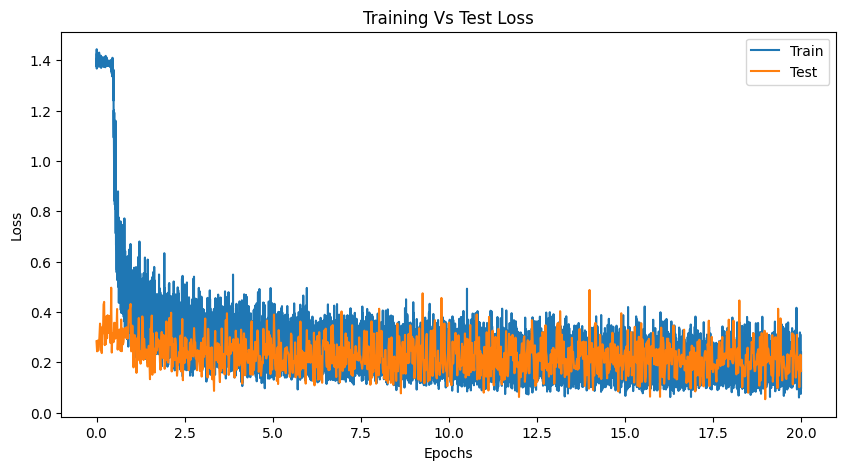

In [18]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_logger)), test_loss_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

Max Test Accuracy 92.88%


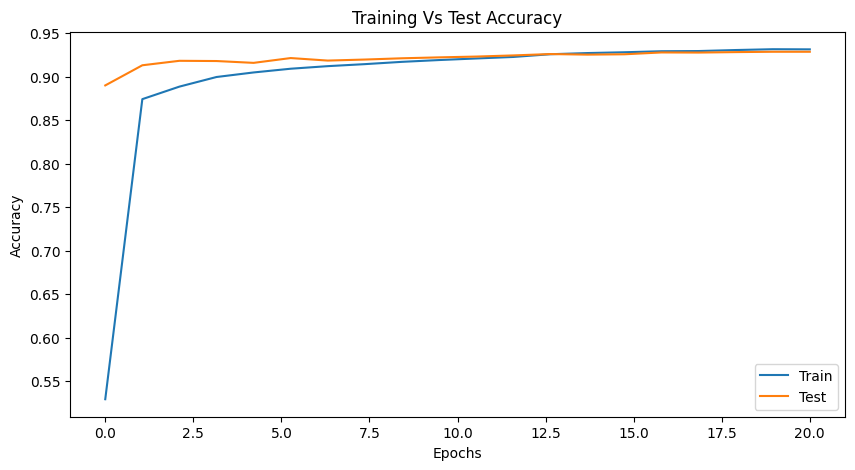

In [19]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_logger)), test_acc_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")
print("Max Test Accuracy %.2f%%" % (np.max(test_acc_logger) * 100))

## Testing!

In [20]:
ag_news_classes = [
    "World",
    "Sports",
    "Business",
    "Science/Technology"
]

with torch.no_grad():
    label, text = next(iter(data_loader_train))
    text_tokens = text_tranform(list(text)).to(device)
    pred, attention_map = tf_classifier(text_tokens)

In [21]:
test_index = 3

# Choose a text index smaller than the total number in the batch!
assert test_index < label.shape[0]

# Select the attention map for a single sample and the first attention head
att_map = attention_map[test_index, 0]
pred_class = ag_news_classes[pred[test_index, -1].argmax().item()]
top5 = att_map.argsort(descending=True)[:5]
top5_tokens = vocab.lookup_tokens(text_tokens[test_index, top5].cpu().numpy())


print("Article:")
print(text[test_index])
print("\nPredicted label:")
print(pred_class)
print("True label:")
print(ag_news_classes[label[test_index].item()])

print("\nTop 5 Tokens:")
print(top5_tokens)

Article:
fiat boss denies end of gm tie-up : fiat chairman luca di montezemolo brushes off media speculation that the carmaker wants to scrap its partnership with general motors.

Predicted label:
Business
True label:
Business

Top 5 Tokens:
['▁motors', '▁fiat', '▁fiat', '▁carmaker', '▁partnership']


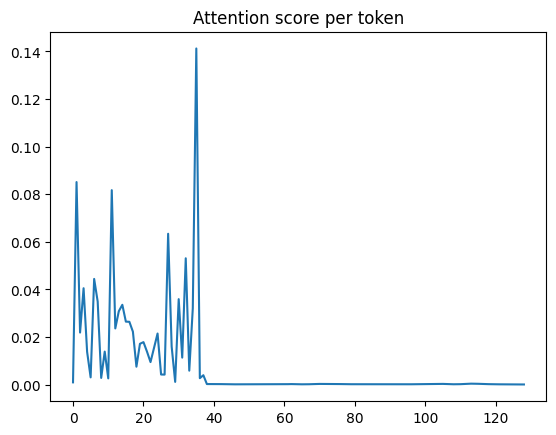

In [22]:
_ = plt.plot(att_map.cpu().numpy())
_ = plt.title("Attention score per token")

In [ ]:

torch.save(tf_classifier.state_dict(), 'nano_transformer_model.pth')
